In [1]:
import matplotlib.pyplot as plt
import numpy as np

from expconfig import TrueBulkICConfig, load_config
from expconfig.synthetic import create_paths, create_synthetic_data
from icprem import PREM_IC_RHO, PREM_IC_VP
from sampling.priors import CompoundPrior, UniformPrior
from tti.traveltimes import TravelTimeCalculator

In [2]:
rng = np.random.default_rng(1234)
normalisation = -1 / (2 * PREM_IC_RHO * (PREM_IC_VP * 1e3) ** 2)

In [3]:
cfg = load_config("../config.yaml")

prior = CompoundPrior.from_dict(cfg.priors.model_dump())
prior_samples = prior.sample(10_000, rng)

In [4]:
if prior.n == 7:
    shear = True
    N = True
elif prior.n == 6:
    shear = True
    N = False
elif prior.n == 5:
    shear = False
    N = False

In [ ]:
truth = TrueBulkICConfig(**cfg.truth.model_dump())
ic_in, ic_out = create_paths(source_spacing=30.0)
synthetic_data = create_synthetic_data(
    TravelTimeCalculator(
        ic_in, ic_out, normalisation=normalisation, nested=False, shear=True, N=True
    ),
    truth.as_array(),
    0.2,
).squeeze()
synthetic_data.shape

(3025,)

In [6]:
prem_prediction = TravelTimeCalculator(
    ic_in, ic_out, normalisation=normalisation, nested=False, shear=shear, N=N
)(np.zeros(prior.n))[0, 0]

In [7]:
ttc = TravelTimeCalculator(
    ic_in, ic_out, normalisation=normalisation, nested=True, shear=shear, N=N
)
prior_predictive = ttc(prior_samples)
prior_predictive.shape

(10000, 3025)

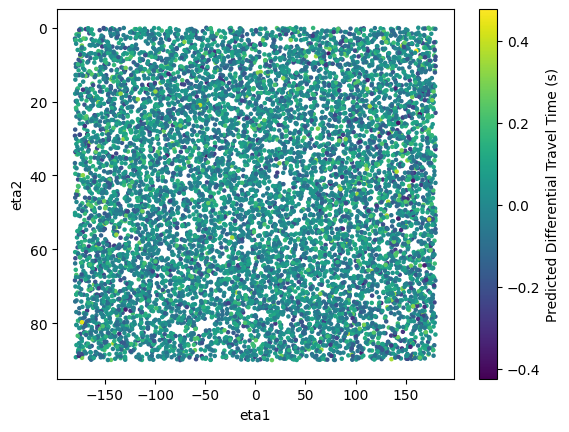

In [8]:
eta1, eta2 = prior_samples[:, -2:].T
plt.scatter(
    eta1,
    eta2,
    c=prior_predictive[:, rng.integers(prior_predictive.shape[1], size=1)],
    cmap="viridis",
    s=5,
)
plt.ylim(95, -5)
plt.xlabel("eta1")
plt.ylabel("eta2")
plt.colorbar(label="Predicted Differential Travel Time (s)")

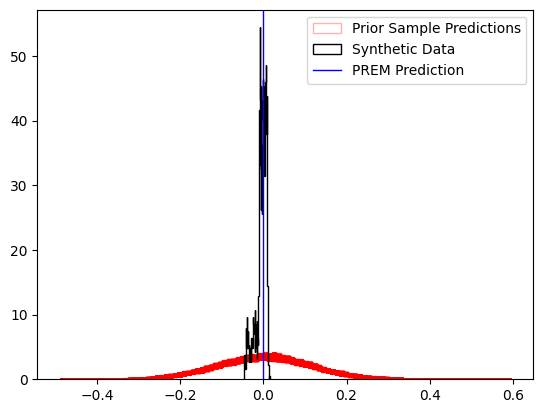

In [9]:
fig, ax = plt.subplots(
    1,
    1,
)
ax.hist(
    prior_predictive,
    alpha=0.3,
    color=np.full(prior_predictive.shape[1], "r"),
    bins=100,
    histtype="step",
    density=True,
    label="Prior Sample Predictions",
)
ax.hist(
    synthetic_data,
    bins=100,
    color="k",
    histtype="step",
    density=True,
    label="Synthetic Data",
)
ax.axvline(
    prem_prediction,
    color="b",
    lw=1,
    label="PREM Prediction",
)
ax.legend()

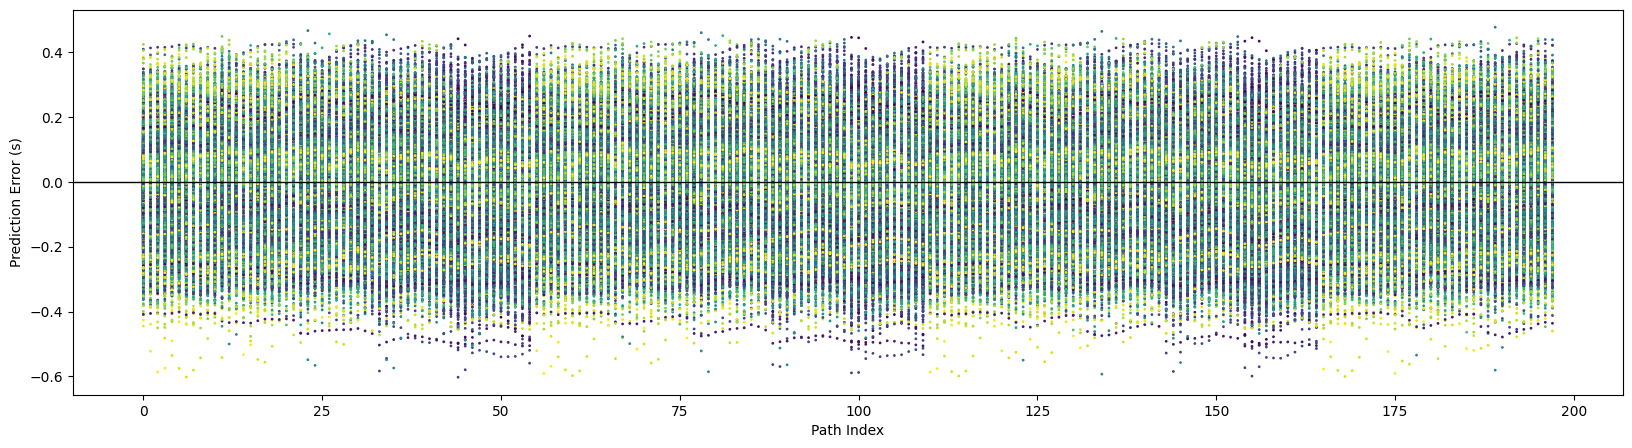

In [10]:
n_outs = 66
max_in_index = 3
n_paths_to_plot = n_outs * max_in_index
diff = synthetic_data[None, :n_paths_to_plot] - prior_predictive[:, :n_paths_to_plot]
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.scatter(
    np.broadcast_to(np.arange(diff.shape[1]), diff.shape),
    diff,
    c=np.broadcast_to(eta2[:, None], diff.shape),
    s=1,
)
ax.set_xlabel("Path Index")
ax.set_ylabel("Prediction Error (s)")
ax.axhline(0.0, color="k", lw=1.0)

In [12]:
ttc = TravelTimeCalculator(
    ic_in, ic_out, normalisation=normalisation, nested=False, shear=True, N=True
)
prior = UniformPrior(np.array([-180.0, 0.0]), np.array([180.0, 90.0]))
prior_samples = prior.sample(10_000, rng)
prior_samples = np.column_stack(
    [
        np.full(len(prior_samples), truth.A),
        np.full(len(prior_samples), truth.C),
        np.full(len(prior_samples), truth.F),
        np.full(len(prior_samples), truth.L),
        np.full(len(prior_samples), truth.N),
        prior_samples,
    ]
)

prior_predictive = ttc(prior_samples)
prior_predictive.shape

(10000, 3025)

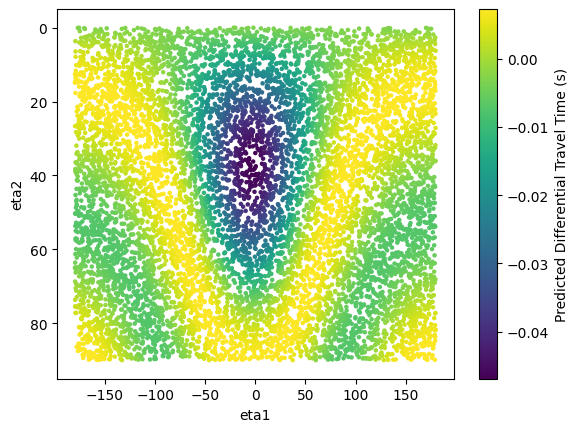

In [13]:
eta1, eta2 = prior_samples[:, -2:].T
plt.scatter(
    eta1,
    eta2,
    c=prior_predictive[:, rng.integers(prior_predictive.shape[1], size=1)],
    cmap="viridis",
    s=5,
)
plt.ylim(95, -5)
plt.xlabel("eta1")
plt.ylabel("eta2")
plt.colorbar(label="Predicted Differential Travel Time (s)")

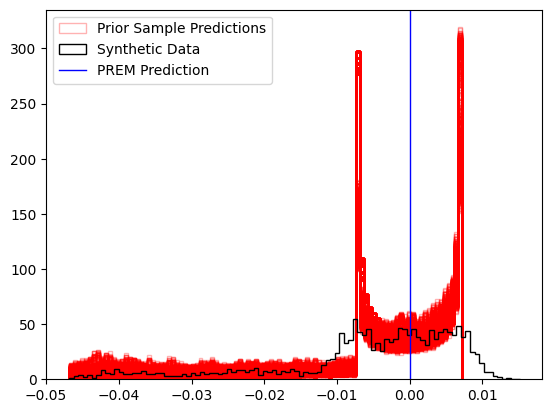

In [14]:
fig, ax = plt.subplots(
    1,
    1,
)
ax.hist(
    prior_predictive,
    alpha=0.3,
    color=np.full(prior_predictive.shape[1], "r"),
    bins=100,
    histtype="step",
    density=True,
    label="Prior Sample Predictions",
)
ax.hist(
    synthetic_data,
    bins=100,
    color="k",
    histtype="step",
    density=True,
    label="Synthetic Data",
)
ax.axvline(
    prem_prediction,
    color="b",
    lw=1,
    label="PREM Prediction",
)
ax.legend()

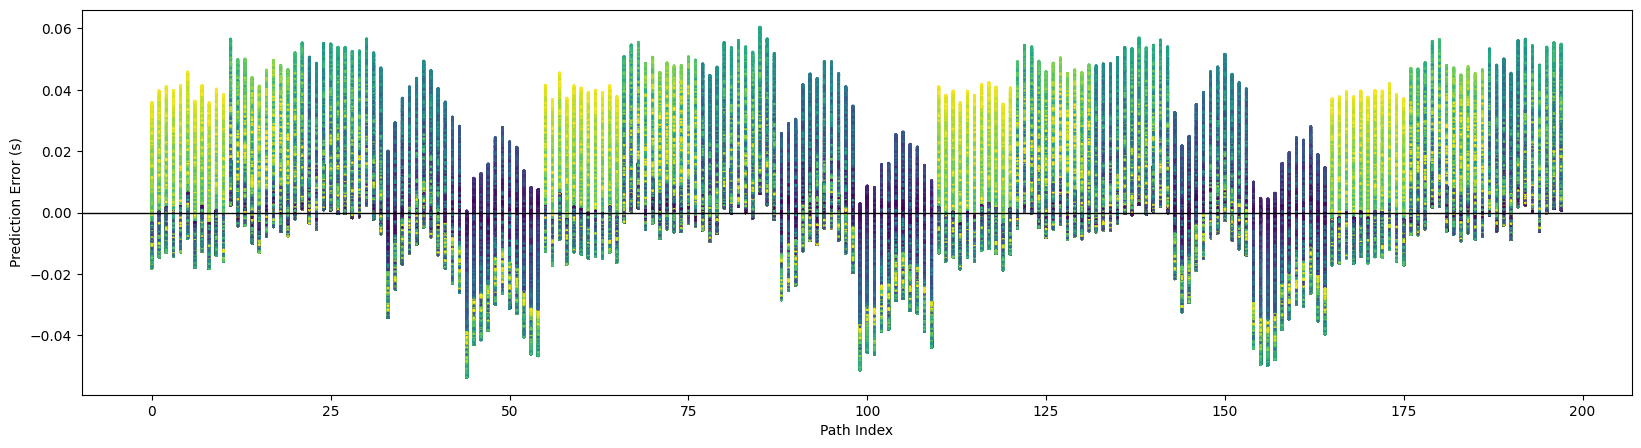

In [15]:
n_outs = 66
max_in_index = 3
n_paths_to_plot = n_outs * max_in_index
diff = synthetic_data[None, :n_paths_to_plot] - prior_predictive[:, :n_paths_to_plot]
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.scatter(
    np.broadcast_to(np.arange(diff.shape[1]), diff.shape),
    diff,
    c=np.broadcast_to(eta2[:, None], diff.shape),
    s=1,
)
ax.set_xlabel("Path Index")
ax.set_ylabel("Prediction Error (s)")
ax.axhline(0.0, color="k", lw=1.0)